In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import graphviz
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

%run utility_functions.py # functions reused throughout

0    16258
1     1639
Name: 0, dtype: int64

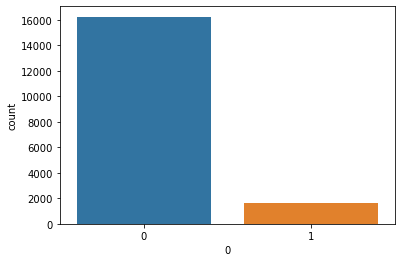

In [2]:
# Dataset source:
# http://archive.ics.uci.edu/ml/datasets/HTRU2#

# Read in data
data = pd.read_csv('../data/HTRU2/HTRU_2.csv', sep=',')

sns.countplot(data.iloc[:,-1]) # plot number of things with each value

data.iloc[:,-1].value_counts(sort=True)
# skewed toward predicting negative

In [3]:
# Create training, testing, and validation sets

X = data.drop(data.columns[-1], axis=1) # last value is the pulsar indicator

y = data.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2) # 80/20 default

# Scale it 
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
x_train = scaling.transform(x_train)
x_test = scaling.transform(x_test)

In [4]:
# reusing 'best' parameters from GridSearch for DT without boosting
# passing max_depth into the gridsearch
# smaller max_depth for boost. 1 or 4
dt = DecisionTreeClassifier(ccp_alpha=0.001, class_weight=None, criterion='entropy',
                       max_depth=1, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0,random_state=0, splitter='best')

parameters = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [50, 100, 200, 300, 400, 500],
              "learning_rate": [.01, .05, 1.0, 1.5, 2.0]
             }
# scorer for parameter combinations
acc_scorer = make_scorer(accuracy_score)

bdt = AdaBoostClassifier(dt, random_state=0)

grid_obj = GridSearchCV(bdt,parameters, scoring=acc_scorer, cv=10, n_jobs=4)
grid_obj = grid_obj.fit(x_train, y_train)

# Set clf to best combination of parameters
clf = grid_obj.best_estimator_

clf.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator__ccp_alpha': 0.001,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': 1,
 'base_estimator__max_features': 'log2',
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 4,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__random_state': 0,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=1,
                        max_features='log2', min_samples_leaf=4, random_state=0),
 'learning_rate': 1.0,
 'n_estimators': 200,
 'random_state': 0}

In [6]:
# train model 
clf.fit(x_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.001,
                                                         criterion='entropy',
                                                         max_depth=1,
                                                         max_features='log2',
                                                         min_samples_leaf=4,
                                                         random_state=0),
                   n_estimators=200, random_state=0)

No Skill: ROC AUC=0.500
Model: ROC AUC=0.978


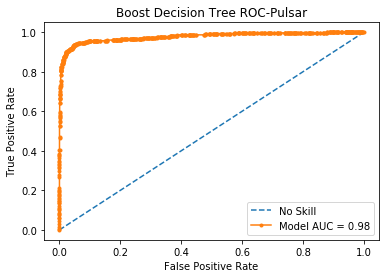

Model: f1=0.871 auc=0.924


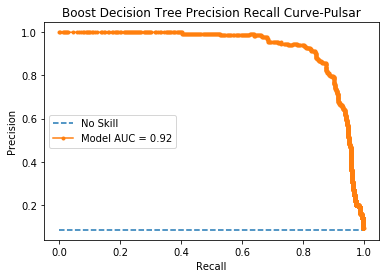

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3277
           1       0.91      0.84      0.87       303

    accuracy                           0.98      3580
   macro avg       0.95      0.92      0.93      3580
weighted avg       0.98      0.98      0.98      3580

Confusion Matrix
[[3251   26]
 [  49  254]]


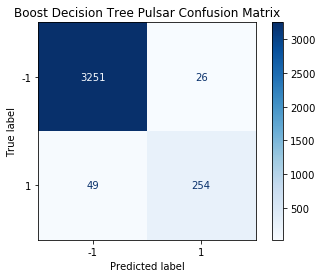

<module 'matplotlib.pyplot' from 'c:\\users\\spcbe\\miniconda3\\envs\\ml_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

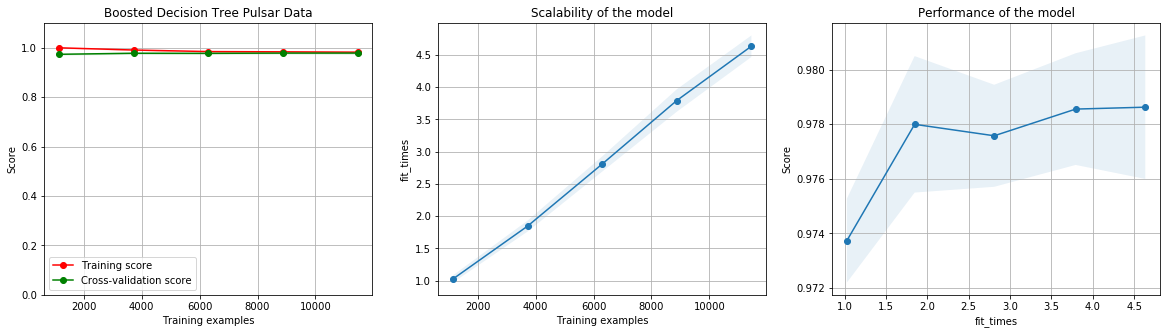

In [7]:
# test
y_predict = clf.predict(x_test)

# ROC
plot_roc(clf, x_test, y_test, y_predict, 'Boost Decision Tree ROC-Pulsar')
# Recall_precision_curve
plot_precision_recall_curve(clf, x_test, y_test, y_predict, 'Boost Decision Tree Precision Recall Curve-Pulsar')

# how did we do? Comparing y_test and predicted values
print('Classification Report')
print(classification_report(y_test, y_predict,zero_division=1))
print('Confusion Matrix')
# how to interpret: https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28
print(confusion_matrix(y_test, y_predict))

cm = plot_confusion_matrix(clf, x_test, y_test,
                                 display_labels=['-1', '1'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
cm.ax_.set_title('Boost Decision Tree Pulsar Confusion Matrix')
plt.savefig('../images/cm_Boost_DT_Pulsar.png')
plt.show()

#print('Accuracy')
#print(accuracy_score(y_test, y_predict))

# for unbalanced data
#print('Balanced Accuracy')
#print(balanced_accuracy_score(y_test, y_predict))

# 1.1 so I can see the top of the plot
plot_learning_curve(clf, "Boosted Decision Tree Pulsar Data", x_train, y_train, ylim=[0,1.1])

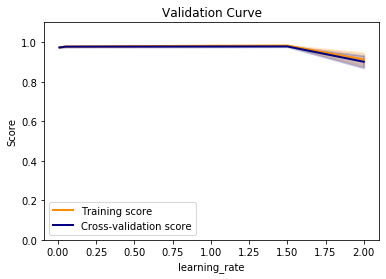

In [9]:
plot_model_complexity_analysis(clf, "learning_rate", [.01, .05, 1.0, 1.5, 2.0], 'Boost_pulsar', x_train, y_train)

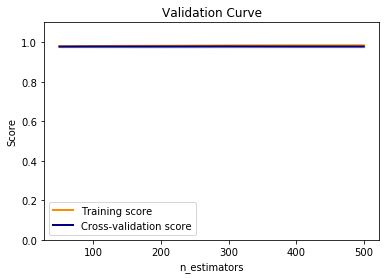

In [10]:
plot_model_complexity_analysis(clf, "n_estimators", [50, 100, 200, 300, 400, 500], 'Boost_pulsar', x_train, y_train)

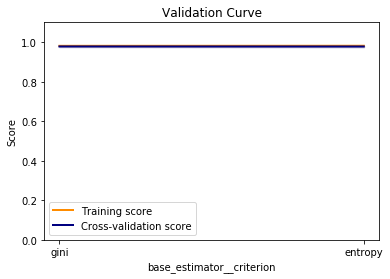

In [11]:
plot_model_complexity_analysis(clf, "base_estimator__criterion", ["gini", "entropy"], 'Boost_pulsar', x_train, y_train)